# Data Preprocessing for Supply Chain Time Series Forecasting

Notebook này dùng để khám phá và tiền xử lý dữ liệu Supply Chain cho bài toán dự đoán chuỗi thời gian.

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Đã import thành công các thư viện cần thiết!")

Đã import thành công các thư viện cần thiết!


In [2]:
# Đọc dữ liệu từ file CSV
data_path = '/home/u1/Desktop/Gra_pr/QT_v2/QTransformer/dataset/DataCoSupplyChain_Synchronized.csv'
df = pd.read_csv(data_path)

# Hiển thị thông tin cơ bản về dataset
print("=== THÔNG TIN CƠ BẢN VỀ DATASET ===")
print(f"Kích thước dataset: {df.shape}")
print(f"Số dòng: {df.shape[0]:,}")
print(f"Số cột: {df.shape[1]}")
print(f"Dung lượng bộ nhớ: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n=== CẤU TRÚC DỮ LIỆU ===")
print(df.info())

=== THÔNG TIN CƠ BẢN VỀ DATASET ===
Kích thước dataset: (147041, 54)
Số dòng: 147,041
Số cột: 54
Dung lượng bộ nhớ: 282.00 MB

=== CẤU TRÚC DỮ LIỆU ===
Dung lượng bộ nhớ: 282.00 MB

=== CẤU TRÚC DỮ LIỆU ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147041 entries, 0 to 147040
Data columns (total 54 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           147041 non-null  object 
 1   Days for shipping (real)       147041 non-null  int64  
 2   Days for shipment (scheduled)  147041 non-null  int64  
 3   Benefit per order              147041 non-null  float64
 4   Sales per customer             147041 non-null  float64
 5   Delivery Status                147041 non-null  object 
 6   Late_delivery_risk             147041 non-null  int64  
 7   Category Id                    147041 non-null  int64  
 8   Category Name                  147041 non-null  object 
 9   Custom

In [3]:
# Hiển thị tên các cột
print("=== DANH SÁCH CÁC CỘT ===")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nTổng cộng: {len(df.columns)} cột")

# Hiển thị vài dòng đầu tiên
print("\n=== MẪU DỮ LIỆU ĐẦU TIÊN ===")
df.head()

=== DANH SÁCH CÁC CỘT ===
 1. Type
 2. Days for shipping (real)
 3. Days for shipment (scheduled)
 4. Benefit per order
 5. Sales per customer
 6. Delivery Status
 7. Late_delivery_risk
 8. Category Id
 9. Category Name
10. Customer City
11. Customer Country
12. Customer Email
13. Customer Fname
14. Customer Id
15. Customer Lname
16. Customer Password
17. Customer Segment
18. Customer State
19. Customer Street
20. Customer Zipcode
21. Department Id
22. Department Name
23. Latitude
24. Longitude
25. Market
26. Order City
27. Order Country
28. Order Customer Id
29. order date (DateOrders)
30. Order Id
31. Order Item Cardprod Id
32. Order Item Discount
33. Order Item Discount Rate
34. Order Item Id
35. Order Item Product Price
36. Order Item Profit Ratio
37. Order Item Quantity
38. Sales
39. Order Item Total
40. Order Profit Per Order
41. Order Region
42. Order State
43. Order Status
44. Order Zipcode
45. Product Card Id
46. Product Category Id
47. Product Description
48. Product Image
49

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,order_date_parsed
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,USCA,Bekasi,Indonesia,20755,01/31/2018 00:10,77202,1360,13.11,0.04,180517,327.750000,0.29,1,327.750000,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class,2018-01-31 00:10:00
1,PAYMENT,5,2,-30.750000,115.180000,Late delivery,1,17,Cleats,Bayamon,Puerto Rico,XXXXXXXXX,Mary,9083,Frank,XXXXXXXXX,Home Office,PR,75 Sunny Grounds,957.0,4,Apparel,18.380119,-66.183128,USCA,Mirzapur,India,9083,07/31/2017 00:17,28744,365,4.80,0.04,71956,59.990002,-0.27,2,119.980003,115.180000,-30.750000,South Asia,Uttar Pradesh,PENDING_PAYMENT,NaN,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,59.990002,0,2/29/2016 13:57,Second Class,2017-07-31 00:17:00
2,PAYMENT,6,2,33.599998,96.000000,Late delivery,1,24,Women's Apparel,Caguas,Puerto Rico,XXXXXXXXX,Elizabeth,639,Pittman,XXXXXXXXX,Home Office,PR,7573 Golden Treasure Centre,725.0,5,Golf,18.025368,-66.613037,USCA,Murray Bridge,Australia,639,09/04/2017 00:03,31115,502,4.00,0.04,77757,50.000000,0.35,2,100.000000,96.000000,33.599998,Oceania,Australia del Sur,PENDING_PAYMENT,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,4/5/2016 4:37,Second Class,2017-09-04 00:03:00
3,PAYMENT,6,2,6.150000,82.000000,Late delivery,1,24,Women's Apparel,Caguas,Puerto Rico,XXXXXXXXX,Mary,8011,Hill,XXXXXXXXX,Home Office,PR,6179 Noble Panda Moor,725.0,5,Golf,18.255713,-66.370506,USCA,Raipur,India,8011,03/31/2017 00:06,20365,502,18.00,0.18,50842,50.000000,0.08,2,100.000000,82.000000,6.150000,South Asia,Rajastán,PENDING_PAYMENT,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,10/31/2015 6:24,Second Class,2017-03-31 00:06:00
4,PAYMENT,2,2,22.410000,74.680000,Shipping on time,0,13,Electronics,Caguas,Puerto Rico,XXXXXXXXX,Mary,3296,Smith,XXXXXXXXX,Home Office,PR,8205 Silver Grove Row,725.0,3,Footwear,18.234663,-66.370598,USCA,Pasco,Estados Unidos,3296,11/16/2017 00:08,36146,278,15.30,0.17,90273,44.990002,0.30,2,89.980003,74.680000,22.410000,West of USA,Washington,PENDING_PAYMENT,99301.0,278,13,NaN,http://images.acmesports.sports/Under+Armour+M...,Under Armour Men's Compression EV SL Slide,44.990002,0,6/13/2016 15:12,Second Class,2017-11-16 00:08:00


In [4]:
# Tìm và phân tích các cột liên quan đến thời gian
print("=== PHÂN TÍCH CÁC CỘT THỜI GIAN ===")

# Tìm các cột có thể chứa thông tin thời gian
time_related_cols = []
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['date', 'time', 'day', 'month', 'year', 'order']):
        time_related_cols.append(col)

print("Các cột có thể chứa thông tin thời gian:")
for col in time_related_cols:
    print(f"- {col}")
    print(f"  Kiểu dữ liệu: {df[col].dtype}")
    print(f"  Số giá trị duy nhất: {df[col].nunique()}")
    print(f"  Mẫu giá trị: {df[col].dropna().head(3).tolist()}")
    print()

# Kiểm tra các cột khác có thể quan trọng
print("=== CÁC CỘT QUAN TRỌNG KHÁC ===")
important_cols = []
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['quantity', 'sales', 'revenue', 'profit', 'price', 'demand']):
        important_cols.append(col)

for col in important_cols:
    print(f"- {col}: {df[col].dtype}, {df[col].nunique()} giá trị duy nhất")

=== PHÂN TÍCH CÁC CỘT THỜI GIAN ===
Các cột có thể chứa thông tin thời gian:
- Days for shipping (real)
  Kiểu dữ liệu: int64
  Số giá trị duy nhất: 7
  Mẫu giá trị: [3, 5, 6]

- Days for shipment (scheduled)
  Kiểu dữ liệu: int64
  Số giá trị duy nhất: 4
  Mẫu giá trị: [4, 2, 2]

- Benefit per order
  Kiểu dữ liệu: float64
  Số giá trị duy nhất: 18915
  Mẫu giá trị: [91.25, -30.75, 33.59999847]

- Order City
  Kiểu dữ liệu: object
  Số giá trị duy nhất: 2827
  Mẫu giá trị: ['Bekasi', 'Mirzapur', 'Murray Bridge']

- Order Country
  Kiểu dữ liệu: object
  Số giá trị duy nhất: 84
  Mẫu giá trị: ['Indonesia', 'India', 'Australia']

- Order Customer Id
  Kiểu dữ liệu: int64
  Số giá trị duy nhất: 12284
  Mẫu giá trị: [20755, 9083, 639]

- order date (DateOrders)
  Kiểu dữ liệu: object
  Số giá trị duy nhất: 48204
  Mẫu giá trị: ['01/31/2018 00:10', '07/31/2017 00:17', '09/04/2017 00:03']

- Order Id
  Kiểu dữ liệu: int64
  Số giá trị duy nhất: 49102
  Mẫu giá trị: [77202, 28744, 31115]

- 

In [5]:
# Thống kê mô tả cho các cột số
print("=== THỐNG KÊ MÔ TẢ CÁC CỘT SỐ ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Tìm thấy {len(numeric_cols)} cột số:")
for col in numeric_cols:
    print(f"- {col}")

print("\nThống kê chi tiết:")
df.describe()

=== THỐNG KÊ MÔ TẢ CÁC CỘT SỐ ===
Tìm thấy 29 cột số:
- Days for shipping (real)
- Days for shipment (scheduled)
- Benefit per order
- Sales per customer
- Late_delivery_risk
- Category Id
- Customer Id
- Customer Zipcode
- Department Id
- Latitude
- Longitude
- Order Customer Id
- Order Id
- Order Item Cardprod Id
- Order Item Discount
- Order Item Discount Rate
- Order Item Id
- Order Item Product Price
- Order Item Profit Ratio
- Order Item Quantity
- Sales
- Order Item Total
- Order Profit Per Order
- Order Zipcode
- Product Card Id
- Product Category Id
- Product Description
- Product Price
- Product Status

Thống kê chi tiết:


,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,147041.000000,24840.000000,147041.000000,147041.000000,0.0,147041.000000,147041.0
mean,3.497596,2.931591,21.454611,179.323835,0.548262,30.125169,6223.841813,35842.584368,5.347379,29.712687,-84.877231,6223.841813,32398.803171,660.809876,20.242004,0.101657,80992.515645,134.090504,0.120296,2.177447,199.565601,179.323835,21.454611,55426.132327,660.809876,30.125169,NaN,134.090504,0.0
std,1.624049,1.374192,97.751153,101.657957,0.497667,13.750241,3610.631753,37514.561794,1.481490,9.811156,21.404860,3610.631753,20799.676604,310.840679,19.808489,0.070408,51992.998597,117.727384,0.468185,1.464278,111.822966,101.657957,97.751153,31919.279101,310.840679,13.750241,NaN,117.727384,0.0
min,0.000000,0.000000,-1844.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025986,1.000000,1.000000,19.000000,0.000000,0.000000,1.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-1844.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.470000,106.589996,0.000000,18.000000,3119.000000,725.000000,4.000000,18.265017,-98.302551,3119.000000,14692.000000,403.000000,5.600000,0.040000,36761.000000,50.000000,0.080000,1.000000,119.980003,106.589996,7.470000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.850000,163.979996,1.000000,29.000000,6170.000000,19148.000000,5.000000,33.144863,-76.773293,6170.000000,29384.000000,627.000000,14.000000,0.090000,73521.000000,59.990002,0.270000,1.000000,199.919998,163.979996,31.850000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.000000,245.960007,1.000000,45.000000,9358.000000,78130.000000,7.000000,39.278301,-66.370583,9358.000000,54098.000000,1004.000000,29.990000,0.160000,135270.000000,199.990005,0.360000,3.000000,299.950012,245.960007,64.000000,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,721.599976,1699.989990,1.000000,76.000000,20757.000000,99205.000000,9.000000,48.781933,115.263077,20757.000000,77204.000000,1363.000000,500.000000,0.250000,180519.000000,1999.989990,0.500000,5.000000,1999.989990,1699.989990,721.599976,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


In [6]:
# Kiểm tra missing values
print("=== KIỂM TRA MISSING VALUES ===")
missing_stats = df.isnull().sum()
missing_percent = (missing_stats / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_stats.index,
    'Missing_Count': missing_stats.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

print("Các cột có missing values:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Kiểm tra duplicate records
print(f"\n=== KIỂM TRA DUPLICATE RECORDS ===")
duplicates = df.duplicated().sum()
print(f"Số dòng trùng lặp: {duplicates}")
print(f"Tỷ lệ trùng lặp: {(duplicates/len(df)*100):.2f}%")

# Kiểm tra unique values cho các cột categorical
print(f"\n=== PHÂN TÍCH CÁC CỘT CATEGORICAL ===")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols[:10]:  # Chỉ hiển thị 10 cột đầu
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} giá trị duy nhất")
    if unique_count <= 20:
        print(f"  Các giá trị: {df[col].unique()[:10].tolist()}")
    print()

=== KIỂM TRA MISSING VALUES ===
Các cột có missing values:
                 Column  Missing_Count  Missing_Percentage
46  Product Description         147041          100.000000
43        Order Zipcode         122201           83.106753

=== KIỂM TRA DUPLICATE RECORDS ===
Các cột có missing values:
                 Column  Missing_Count  Missing_Percentage
46  Product Description         147041          100.000000
43        Order Zipcode         122201           83.106753

=== KIỂM TRA DUPLICATE RECORDS ===
Số dòng trùng lặp: 0
Tỷ lệ trùng lặp: 0.00%

=== PHÂN TÍCH CÁC CỘT CATEGORICAL ===
Type: 4 giá trị duy nhất
  Các giá trị: ['DEBIT', 'PAYMENT', 'TRANSFER', 'CASH']

Delivery Status: 4 giá trị duy nhất
  Các giá trị: ['Advance shipping', 'Late delivery', 'Shipping on time', 'Shipping canceled']

Category Name: 36 giá trị duy nhất

Customer City: 562 giá trị duy nhất

Customer Country: 2 giá trị duy nhất
  Các giá trị: ['Puerto Rico', 'EE. UU.']

Customer Email: 1 giá trị duy nhất
  Cá

=== TẠO BIỂU ĐỒ PHÂN TÍCH DỮ LIỆU ===


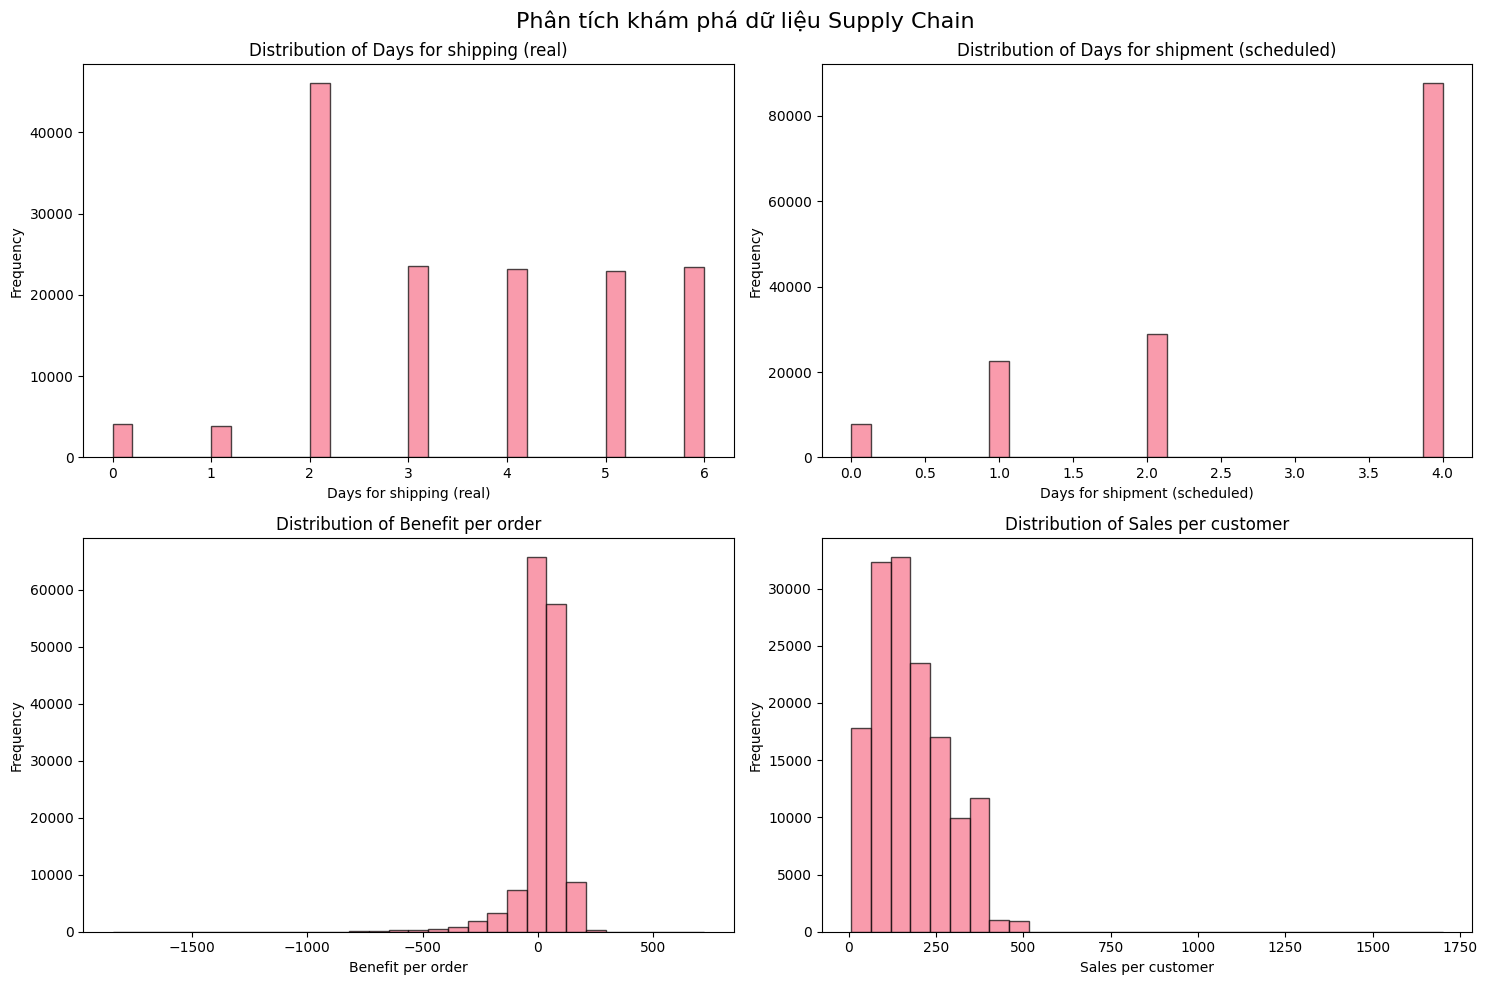

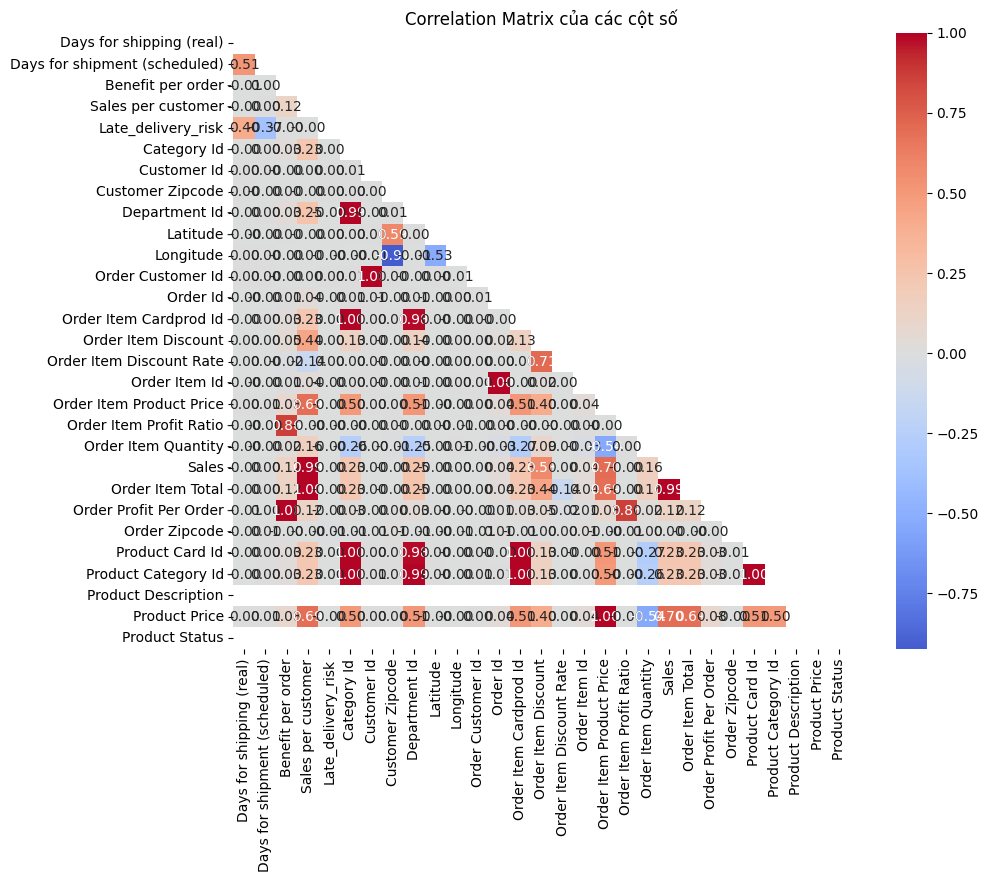

Đã tạo xong các biểu đồ phân tích!


In [7]:
# Tạo visualization để hiểu dữ liệu
print("=== TẠO BIỂU ĐỒ PHÂN TÍCH DỮ LIỆU ===")

# Thiết lập figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Phân tích khám phá dữ liệu Supply Chain', fontsize=16)

# 1. Distribution của các cột số quan trọng
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 0:
    # Chọn một vài cột số đầu tiên để vẽ histogram
    for i, col in enumerate(numeric_cols[:4]):
        row = i // 2
        col_idx = i % 2
        if i < 4:
            axes[row, col_idx].hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
            axes[row, col_idx].set_title(f'Distribution of {col}')
            axes[row, col_idx].set_xlabel(col)
            axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2. Correlation matrix cho các cột số
if len(numeric_cols) > 1:
    plt.figure(figsize=(12, 8))
    # Tính correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Tạo heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f')
    plt.title('Correlation Matrix của các cột số')
    plt.show()

print("Đã tạo xong các biểu đồ phân tích!")

## Tóm tắt phân tích dữ liệu Supply Chain

### Đặc điểm chính của dataset:
- **Kích thước**: 147,041 dòng × 54 cột
- **Dung lượng**: ~282 MB
- **Không có dữ liệu trùng lặp**

### Các cột thời gian quan trọng:
1. **`order date (DateOrders)`**: Ngày đặt hàng (48,204 giá trị duy nhất)
2. **`shipping date (DateOrders)`**: Ngày giao hàng (47,619 giá trị duy nhất) 
3. **`order_date_parsed`**: Ngày đặt hàng đã được parse

### Biến mục tiêu tiềm năng cho dự đoán chuỗi thời gian:
- **`Order Item Quantity`**: Số lượng sản phẩm trong đơn hàng (1-5)
- **`Sales`**: Doanh thu (179 giá trị duy nhất)
- **`Order Item Total`**: Tổng giá trị đơn hàng
- **`Order Profit Per Order`**: Lợi nhuận trên đơn hàng

### Thông tin địa lý:
- **84 quốc gia**, **16 khu vực**, **600 bang/tỉnh**
- Tập trung chủ yếu ở **Puerto Rico** và **EE.UU.**

### Vấn đề cần xử lý:
- **Missing values**: `Product Description` (100%), `Order Zipcode` (83%)
- Cần chuyển đổi cột thời gian từ string sang datetime
- Cần tạo features thời gian (ngày, tháng, năm, quý, tuần)

In [3]:
# Import plotly cho biểu đồ tương tác
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Thiết lập plotly để hiển thị trong notebook
pyo.init_notebook_mode(connected=True)

print("Đã import thành công plotly cho biểu đồ tương tác!")

Đã import thành công plotly cho biểu đồ tương tác!


In [4]:
# Tiền xử lý dữ liệu thời gian cho biểu đồ
print("=== TIỀN XỬ LÝ DỮ LIỆU THỜI GIAN ===")

# Convert cột order date thành datetime
df['order_datetime'] = pd.to_datetime(df['order date (DateOrders)'], format='%m/%d/%Y %H:%M', errors='coerce')

# Tạo cột ngày (chỉ lấy phần date, không có time)
df['order_date_only'] = df['order_datetime'].dt.date

# Kiểm tra kết quả conversion
print(f"Phạm vi thời gian: {df['order_datetime'].min()} đến {df['order_datetime'].max()}")
print(f"Tổng số ngày duy nhất: {df['order_date_only'].nunique()}")

# Kiểm tra các Market và Order Region
print(f"\nSố Market duy nhất: {df['Market'].nunique()}")
print(f"Các Market: {df['Market'].unique()}")
print(f"\nSố Order Region duy nhất: {df['Order Region'].nunique()}")
print(f"Các Order Region: {df['Order Region'].unique()}")

=== TIỀN XỬ LÝ DỮ LIỆU THỜI GIAN ===
Phạm vi thời gian: 2017-01-18 02:48:00 đến 2018-01-31 23:59:00
Tổng số ngày duy nhất: 309

Số Market duy nhất: 3
Các Market: ['USCA' 'Europe' 'LATAM']

Số Order Region duy nhất: 16
Các Order Region: ['Southeast Asia' 'South Asia' 'Oceania' 'West of USA ' 'US Center '
 'Western Europe' 'Northern Europe' 'Central America' 'Caribbean'
 'South America' 'Southern Europe' 'East of USA' 'Eastern Asia'
 'South of  USA ' 'Eastern Europe' 'West Asia']


In [5]:
# Biểu đồ 1: Tổng số order theo ngày và Market
print("=== BIỂU ĐỒ 1: TỔNG SỐ ORDER THEO MARKET ===")

# Tổng hợp dữ liệu theo ngày và Market
daily_orders_by_market = df.groupby(['order_date_only', 'Market']).size().reset_index(name='total_orders')
daily_orders_by_market['order_date_only'] = pd.to_datetime(daily_orders_by_market['order_date_only'])

# Tạo biểu đồ tương tác với plotly
fig1 = px.line(daily_orders_by_market, 
               x='order_date_only', 
               y='total_orders',
               color='Market',
               title='📈 Tổng số Orders theo thời gian - phân chia theo Market',
               labels={
                   'order_date_only': 'Ngày đặt hàng',
                   'total_orders': 'Tổng số Orders',
                   'Market': 'Thị trường'
               },
               template='plotly_white')

# Cải thiện giao diện
fig1.update_layout(
    height=600,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Thêm hover information
fig1.update_traces(
    hovertemplate='<b>%{fullData.name}</b><br>' +
                  'Ngày: %{x}<br>' +
                  'Số Orders: %{y:,}<br>' +
                  '<extra></extra>'
)

fig1.show()

print(f"Biểu đồ hiển thị {len(daily_orders_by_market['Market'].unique())} Markets trên {daily_orders_by_market['order_date_only'].nunique()} ngày")

=== BIỂU ĐỒ 1: TỔNG SỐ ORDER THEO MARKET ===


Biểu đồ hiển thị 3 Markets trên 309 ngày


In [6]:
# Biểu đồ 2: Tổng số order theo ngày và Order Region
print("=== BIỂU ĐỒ 2: TỔNG SỐ ORDER THEO ORDER REGION ===")

# Tổng hợp dữ liệu theo ngày và Order Region
daily_orders_by_region = df.groupby(['order_date_only', 'Order Region']).size().reset_index(name='total_orders')
daily_orders_by_region['order_date_only'] = pd.to_datetime(daily_orders_by_region['order_date_only'])

# Tạo biểu đồ tương tác với plotly
fig2 = px.line(daily_orders_by_region, 
               x='order_date_only', 
               y='total_orders',
               color='Order Region',
               title='🌍 Tổng số Orders theo thời gian - phân chia theo Order Region',
               labels={
                   'order_date_only': 'Ngày đặt hàng',
                   'total_orders': 'Tổng số Orders',
                   'Order Region': 'Khu vực đặt hàng'
               },
               template='plotly_white')

# Cải thiện giao diện
fig2.update_layout(
    height=600,
    hovermode='x unified',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

# Thêm hover information
fig2.update_traces(
    hovertemplate='<b>%{fullData.name}</b><br>' +
                  'Ngày: %{x}<br>' +
                  'Số Orders: %{y:,}<br>' +
                  '<extra></extra>'
)

fig2.show()

print(f"Biểu đồ hiển thị {len(daily_orders_by_region['Order Region'].unique())} Regions trên {daily_orders_by_region['order_date_only'].nunique()} ngày")

=== BIỂU ĐỒ 2: TỔNG SỐ ORDER THEO ORDER REGION ===


Biểu đồ hiển thị 16 Regions trên 309 ngày


In [7]:
# Thống kê tóm tắt về trends
print("=== THỐNG KÊ TÓM TẮT VỀ TRENDS ===")

# Top Markets theo tổng số orders
market_totals = df.groupby('Market').size().sort_values(ascending=False)
print("🏆 TOP MARKETS theo tổng số orders:")
for i, (market, total) in enumerate(market_totals.head().items(), 1):
    print(f"{i}. {market}: {total:,} orders")

print()

# Top Order Regions theo tổng số orders  
region_totals = df.groupby('Order Region').size().sort_values(ascending=False)
print("🌟 TOP ORDER REGIONS theo tổng số orders:")
for i, (region, total) in enumerate(region_totals.head().items(), 1):
    print(f"{i}. {region}: {total:,} orders")

print()

# Thống kê orders trung bình mỗi ngày
daily_total = df.groupby('order_date_only').size()
print(f"📊 THỐNG KÊ ORDERS THEO NGÀY:")
print(f"- Trung bình: {daily_total.mean():.1f} orders/ngày")
print(f"- Cao nhất: {daily_total.max():,} orders ({daily_total.idxmax()})")
print(f"- Thấp nhất: {daily_total.min():,} orders ({daily_total.idxmin()})")
print(f"- Độ lệch chuẩn: {daily_total.std():.1f}")

# Kiểm tra trend theo thời gian
print(f"\n⏰ PHẠM VI THỜI GIAN:")
print(f"- Từ: {df['order_datetime'].min().strftime('%d/%m/%Y')}")
print(f"- Đến: {df['order_datetime'].max().strftime('%d/%m/%Y')}")
print(f"- Tổng số ngày: {(df['order_datetime'].max() - df['order_datetime'].min()).days} ngày")

=== THỐNG KÊ TÓM TẮT VỀ TRENDS ===
🏆 TOP MARKETS theo tổng số orders:
1. USCA: 52,502 orders
2. LATAM: 51,594 orders
3. Europe: 42,945 orders

🌟 TOP ORDER REGIONS theo tổng số orders:
1. Central America: 28,341 orders
2. Western Europe: 25,215 orders
3. South America: 14,935 orders
4. Northern Europe: 9,006 orders
5. Oceania: 8,728 orders

📊 THỐNG KÊ ORDERS THEO NGÀY:
- Trung bình: 475.9 orders/ngày
- Cao nhất: 584 orders (2017-11-02)
- Thấp nhất: 49 orders (2017-01-18)
- Độ lệch chuẩn: 83.3

⏰ PHẠM VI THỜI GIAN:
- Từ: 18/01/2017
- Đến: 31/01/2018
- Tổng số ngày: 378 ngày


## 📋 MULTI-STEP vs SINGLE-STEP ANALYSIS

### **Single-step (Autoregressive):**
```
Day 1: [X1, X2, ...Xn] → pred_day1
Day 2: [X2, X3, ...Xn, pred_day1] → pred_day2
Day 3: [X3, X4, ...Xn, pred_day1, pred_day2] → pred_day3
...
```
**Ưu điểm:** Flexible, có thể predict unlimited horizon
**Nhược điểm:** Error accumulation, chậm hơn

### **Multi-step (Direct):**
```
Input: [X1, X2, ...Xn] → [pred_day1, pred_day2, ..., pred_day7]
```
**Ưu điểm:** No error accumulation, nhanh hơn, stable
**Nhược điểm:** Fixed horizon, cần nhiều data hơn

### **Recommendation cho Supply Chain:**
**→ Multi-step (Direct)** vì:
1. **Fixed horizon 7 ngày** phù hợp business planning
2. **No error accumulation** quan trọng với supply chain
3. **Faster inference** khi production deployment
4. **More stable** cho business critical decisions

## 🎯 LOSS FUNCTION RECOMMENDATIONS

### **Option 1: Weighted MSE (Time-based)**
```python
weights = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]  # Day 1-7
loss = weighted_mse(y_true, y_pred, weights)
```
**Lý do:** Recent predictions quan trọng hơn cho immediate planning

### **Option 2: Market-balanced Loss**
```python
market_weights = {'USCA': 0.4, 'LATAM': 0.35, 'Europe': 0.25}  # Based on volume
loss = market_weighted_mse(y_true, y_pred, market_weights)
```
**Lý do:** Balance prediction quality across markets

### **Option 3: Hybrid Loss (Recommended)**
```python
time_weights = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
market_weights = [0.4, 0.35, 0.25]
loss = hybrid_weighted_loss(y_true, y_pred, time_weights, market_weights)
```
**Ưu điểm:** 
- Prioritize short-term accuracy
- Balance market importance
- More business-relevant

## ✅ STRATEGY FINALIZED

### **📄 Detailed Documentation Created:**
**File:** `/home/u1/Desktop/Gra_pr/QT_v2/QTransformer/DATA_PREPROCESSING_README.md`

### **🎯 Final Strategy Summary:**

#### **Model Architecture:**
- **QCAAPatchTF_Embedding** (Modified for multi-market output)
- **Input:** [batch, 60_days, 39_features] 
- **Output:** [batch, 7_days, 3_markets]

#### **Key Decisions:**
1. **Multi-step Direct Prediction** (all 7 days at once)
2. **Hybrid Weighted Loss** (time + market importance)
3. **Time Series Split** (70% train, 15% val, 15% test)
4. **39 Features Total:** 9 numerical + 6 time + 24 embedded

#### **Expected Pipeline:**
```
Raw Data → Daily Aggregation → Feature Engineering → 
Outlier Cleaning → Time Series Format → Model Training → 
Multi-Market Predictions
```

### **🚀 Ready for Implementation Phase!**
All major architectural decisions finalized. README file serves as:
- ✅ **Implementation roadmap**
- ✅ **Technical documentation** 
- ✅ **Project tracking system**
- ✅ **Decision audit trail**